In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn import impute
from sklearn import model_selection, preprocessing, decomposition, cluster, metrics
import scikitplot as skplt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import warnings
warnings.filterwarnings('ignore')

# 1

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

In [3]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
float_type_count = 0
object_type_count = 0
for i in data:
    if data[i].dtype == float:
        float_type_count += 1
    if data[i].dtype == object:
        object_type_count += 1
print(f'float: {float_type_count}, object: {object_type_count}')

float: 62, object: 5


# 2

Вопрос: что лучше предсказывать: новые случаи, или новые случаи на миллион?

In [57]:
columns = ['total_cases', 'new_cases', 'new_cases_smoothed', 
           'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million']
data[columns].tail(8)

,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million
181945,247297.0,0.0,29.000,16385.780,0.000,1.922
181946,247336.0,39.0,25.143,16388.365,2.584,1.666
181947,247383.0,47.0,25.000,16391.479,3.114,1.656
181948,247488.0,105.0,35.857,16398.436,6.957,2.376
181949,247524.0,36.0,41.000,16400.821,2.385,2.717
181950,247524.0,0.0,35.143,16400.821,0.000,2.329
181951,247598.0,74.0,43.000,16405.725,4.903,2.849
181952,247667.0,69.0,52.857,16410.296,4.572,3.502


In [59]:
data[columns].tail(7)['new_cases_per_million'].sum() / 7

3.5021428571428572

In [71]:
data[columns]['total_cases_per_million'].values[-1:] * data['population'].values[-1:]

array([2.47666993e+11])

Будем предсказывать 'new_cases_smoothed_per_million', из которого можно вывести 'total_cases_per_million', и путем умножения на 'population' страны 'total_cases'.
'new_cases_smoothed_per_million' - дает сглаженную оценку за неделю, из-за чего значения меньше колеблятся
Аналогично с 'total_deaths'

<AxesSubplot:>

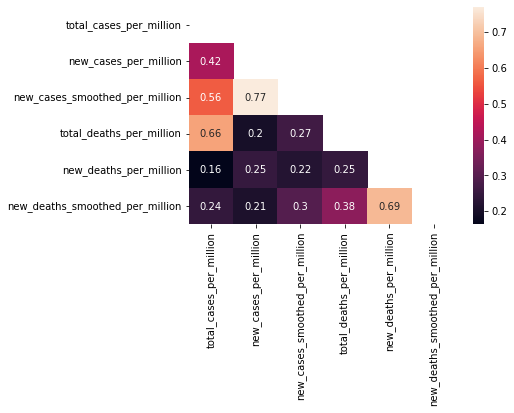

In [87]:
columns = ['total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million',
          'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million']
sns.heatmap(data[columns].corr(), annot=True, mask=np.triu(data[columns].corr()))

Показатели 'excess_mortality', 'excess_mortality_cumulative', 
 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative_per_million' отвечают за стаистику прогнозируемых и фактических смертей и не имеют отношения к решваемой задаче

In [108]:
columns = ['icu_patients_per_million', 'hosp_patients_per_million', 
           'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million']
data.groupby('location')[columns].sum()

,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million
location,,,,
Afghanistan,0.000,0.0,0.0,0.0
Africa,0.000,0.0,0.0,0.0
Albania,0.000,0.0,0.0,0.0
Algeria,365.221,0.0,0.0,0.0
Andorra,0.000,0.0,0.0,0.0
...,...,...,...,...
Western Sahara,0.000,0.0,0.0,0.0
World,0.000,0.0,0.0,0.0
Yemen,0.000,0.0,0.0,0.0


In [111]:
data[data['location']=='Afghanistan'][columns].dropna()

,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million


<AxesSubplot:>

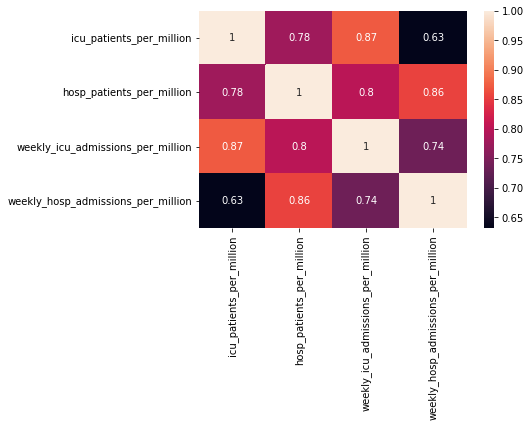

In [101]:
sns.heatmap(data[columns].corr(), annot=True)

In [51]:
data[['date', 'stringency_index']].dropna()

,date,stringency_index
0,2020-02-24,8.33
1,2020-02-25,8.33
2,2020-02-26,8.33
3,2020-02-27,8.33
4,2020-02-28,8.33
...,...,...
181933,2022-04-07,61.11
181934,2022-04-08,61.11
181935,2022-04-09,61.11
181936,2022-04-10,61.11


In [50]:
data[['date', 'reproduction_rate']].dropna()

,date,reproduction_rate
34,2020-03-29,1.51
35,2020-03-30,1.51
36,2020-03-31,1.53
37,2020-04-01,1.52
38,2020-04-02,1.51
...,...,...
181945,2022-04-19,0.70
181946,2022-04-20,0.75
181947,2022-04-21,0.80
181948,2022-04-22,0.84


In [52]:
data['population_density']

0         54.422
1         54.422
2         54.422
3         54.422
4         54.422
           ...  
181948    42.729
181949    42.729
181950    42.729
181951    42.729
181952    42.729
Name: population_density, Length: 181953, dtype: float64